This notebook contains ratio plots between data and background MC for BDT variables distribution.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
import uproot

import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.correction import get_pu_weights_function, get_ttbar_weight, get_nlo_weight_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

########## backgrounds ##########
bkgdatasets_=json.load(open('../../MC/Samples/backgrounds_nonempty.json'))
bkgscales_=json.load(open('../../MC/Samples/backgrounds_scale.json'))

# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        files = bkgdatasets_[group][tag]
        bkgdatasets[tag] = {'files': files, 'treename': 'ffNtuplizer/ffNtuple'}

# flatten scales
bkgscales = {}
for group in bkgscales_:
    for tag in bkgscales_[group]:
        bkgscales[tag] = bkgscales_[group][tag]

lumi = 59.74*1e3
for k in bkgscales:
    bkgscales[k] *= lumi

# mapping
bkgmapping = {}
for k in bkgdatasets_: bkgmapping[k] = list(bkgdatasets_[k])
####################################

########## data ##########
datadatasets_=json.load(open('../Samples/control_data2018.json'))
datadatasets = dict(
    A={'files': datadatasets_['A'], 'treename': 'ffNtuplizer/ffNtuple'},
    B={'files': datadatasets_['B'], 'treename': 'ffNtuples/ffNtuple'},
    C={'files': datadatasets_['C'], 'treename': 'ffNtuples/ffNtuple'},
    D={'files': datadatasets_['D'], 'treename': 'ffNtuples/ffNtuple'},
)
datamapping = {'data': list('ABCD')}
####################################

########## combine together ##########
datasets = {}
datasets.update(bkgdatasets)
datasets.update(datadatasets)

mapping = {}
mapping.update(bkgmapping)
mapping.update(datamapping)
####################################

In [3]:
# using regular expressions on dataset name to select just the data
# another method would be to fill a separate data histogram
import re
notdata = re.compile('(?!data)')

Let's give a shot on leptonJet's pT(, mass, multiplicity per event) in control region

In [4]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset list')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", 80, 0, 800)
        mass_axis = hist.Bin("mass", "mass [GeV]", 50, 0, 100)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "pt": hist.Hist("#counts/10GeV", dataset_axis, pt_axis),
            "mass": hist.Hist("#counts/2GeV", dataset_axis, mass_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'],
                    py=df['gen_p4.fCoordinates.fY'],
                    pz=df['gen_p4.fCoordinates.fZ'],
                    energy=df['gen_p4.fCoordinates.fT'],
                    pid=df['gen_pid'],
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
        leptonjets_ = dileptonjets[controlregion.flatten()]
        wgt = wgt[controlregion.flatten()]
        wgts= (leptonjets_.pt.ones_like()*wgt).flatten()
        
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt)
        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=wgts)
        output['mass'].fill(dataset=dataset, mass=leptonjets_.mass.flatten(), weight=wgts)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset') # scale
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping) # cat grouping
        return accumulator

In [6]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 6847/6847 [08:13<00:00,  7.08items/s]


In [7]:
# common plotting options

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:313: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:320: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:871: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:334: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)


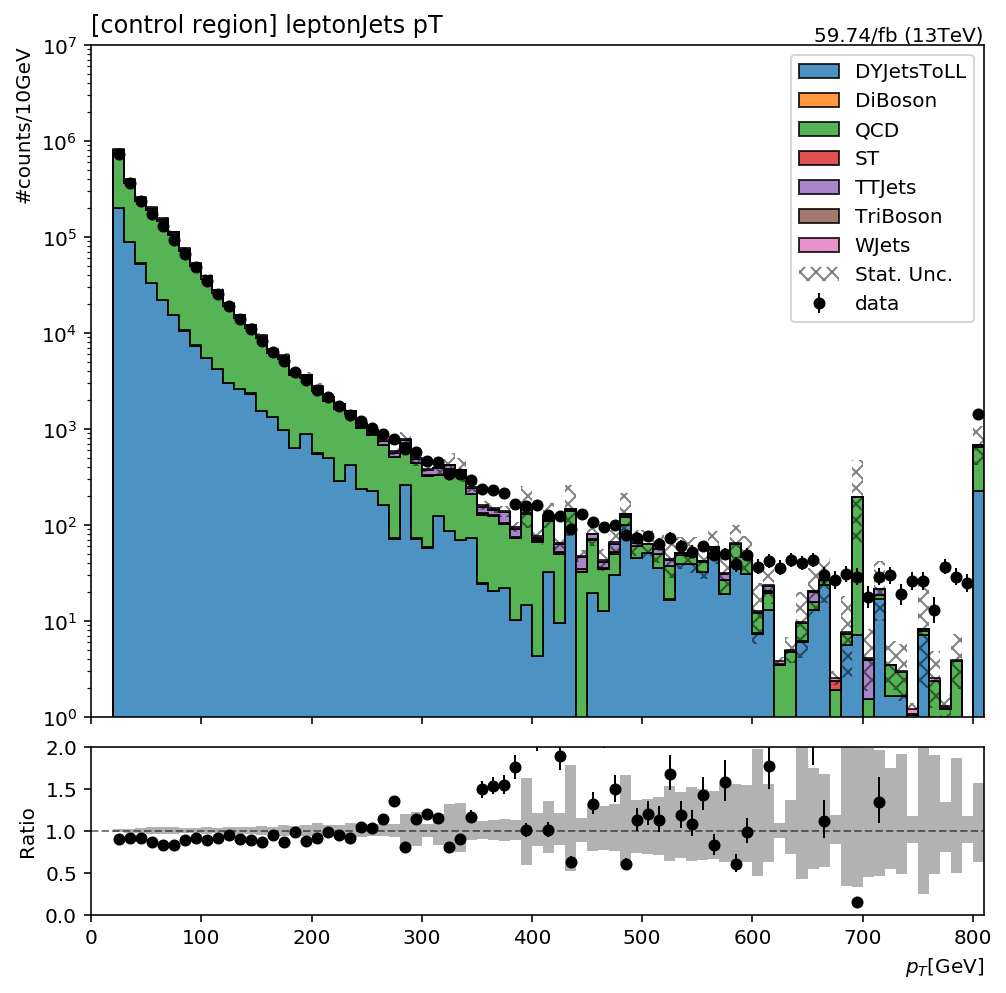

In [8]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['pt_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['pt_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['pt_cat']['data'].sum('cat'), output['pt_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets pT', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

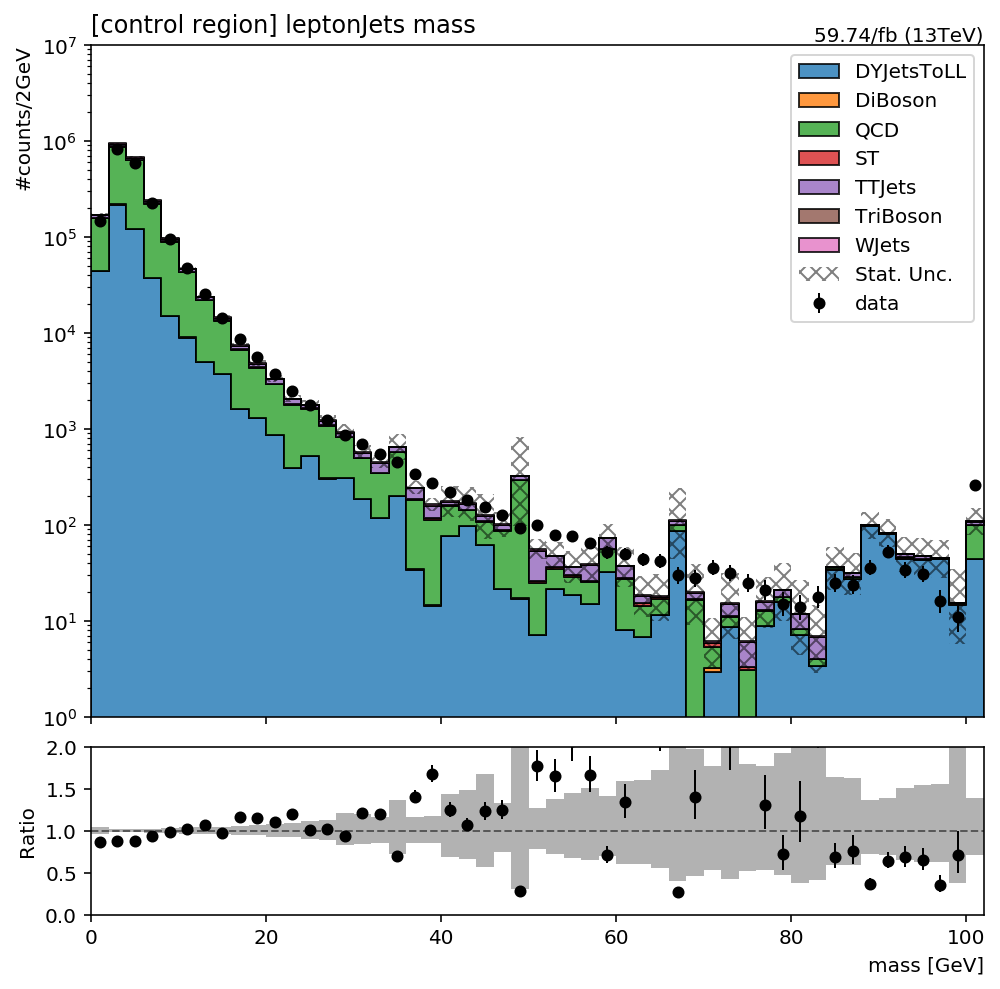

In [9]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['mass_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['mass_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['mass_cat']['data'].sum('cat'), output['mass_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets mass', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

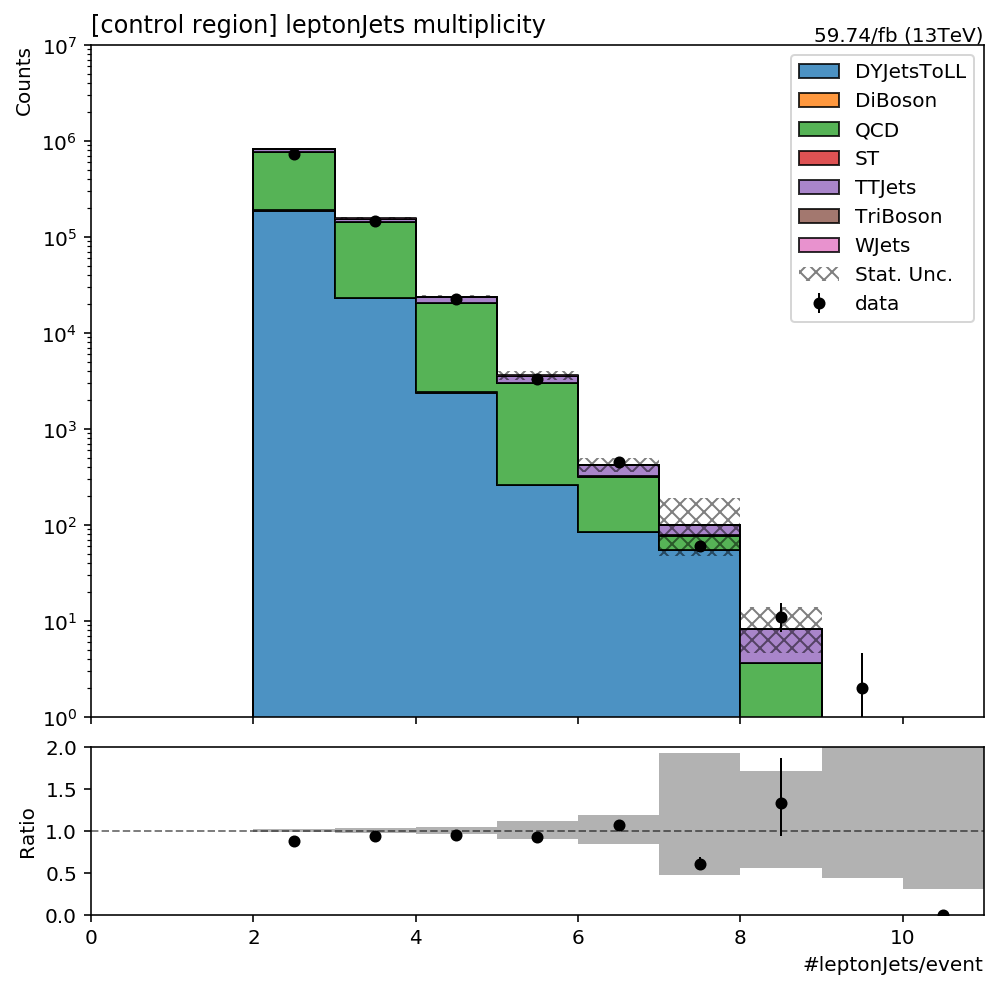

In [11]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['multi_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['multi_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['multi_cat']['data'].sum('cat'), output['multi_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets multiplicity', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

## Variables as input for BDT
- leptonJet pT, eta
- neutral energy fraction
- maxd0, mind0
- tkiso, pfiso
- spreadpt, spreaddr
- lambda, epsilon
- ecf 1,2,3

and
- BDT score

In [14]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1.001)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 200)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 500)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 300)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis),
            "nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis),
            "lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis),
            "epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis),
            "ecfe1": hist.Hist("#counts/4", dataset_axis, ecfe1_axis),
            "ecfe2": hist.Hist("#counts/10", dataset_axis, ecfe2_axis),
            "ecfe3": hist.Hist("#counts/6", dataset_axis, ecfe3_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'],
                    py=df['gen_p4.fCoordinates.fY'],
                    pz=df['gen_p4.fCoordinates.fZ'],
                    energy=df['gen_p4.fCoordinates.fT'],
                    pid=df['gen_pid'],
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        absd0 = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0)
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=absd0.max().content,
            mind0=absd0.min().content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
        leptonjets_ = dileptonjets[controlregion.flatten()]
        wgt = wgt[controlregion.flatten()]
        wgts= (leptonjets_.pt.ones_like()*wgt).flatten()

        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), weight=wgts)
        output['eta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), weight=wgts)
        output['nef'].fill(dataset=dataset, nef=leptonjets_.nef.flatten(), weight=wgts)
        output['maxd0'].fill(dataset=dataset, maxd0=leptonjets_.maxd0.flatten(), weight=wgts)
        output['mind0'].fill(dataset=dataset, mind0=leptonjets_.mind0.flatten(), weight=wgts)
        output['tkiso'].fill(dataset=dataset, tkiso=leptonjets_.tkiso.flatten(), weight=wgts)
        output['pfiso'].fill(dataset=dataset, pfiso=leptonjets_.pfiso.flatten(), weight=wgts)
        output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets_.spreadpt.flatten(), weight=wgts)
        output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets_.spreaddr.flatten(), weight=wgts)
        output['lamb'].fill(dataset=dataset, lamb=leptonjets_.lamb.flatten(), weight=wgts)
        output['epsi'].fill(dataset=dataset, epsi=leptonjets_.epsi.flatten(), weight=wgts)
        output['ecfe1'].fill(dataset=dataset, ecfe1=leptonjets_.ecf1.flatten(), weight=wgts)
        output['ecfe2'].fill(dataset=dataset, ecfe2=leptonjets_.ecf2.flatten(), weight=wgts)
        output['ecfe3'].fill(dataset=dataset, ecfe3=leptonjets_.ecf3.flatten(), weight=wgts)
        output['mva'].fill(dataset=dataset, mva=leptonjets_.mva.flatten(), weight=wgts)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        
        for k in origidentity:
            # scale
            accumulator[k].scale(bkgscales, axis='dataset')
            # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        
        return accumulator

In [15]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 6847/6847 [11:51<00:00,  7.01items/s]


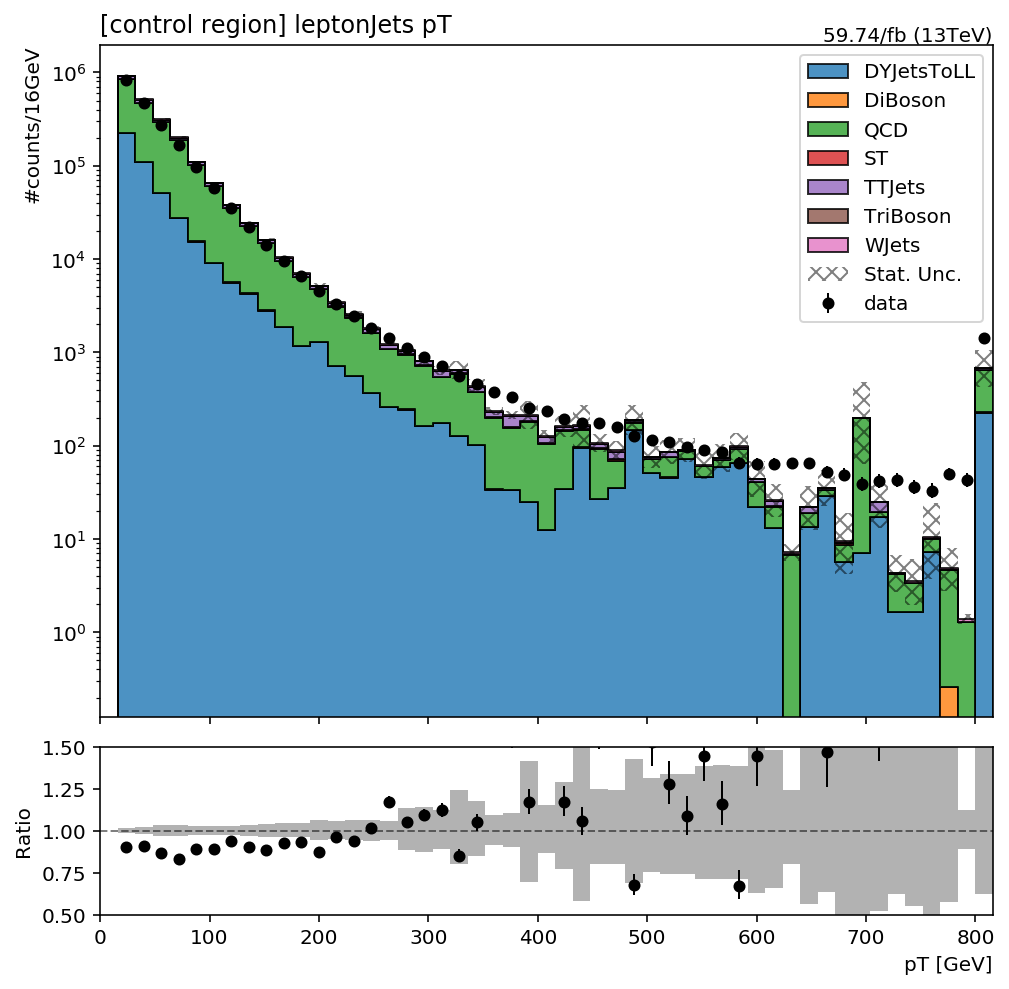

In [49]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['pt_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['pt_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['pt_cat']['data'].sum('cat'), output['pt_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets pT', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

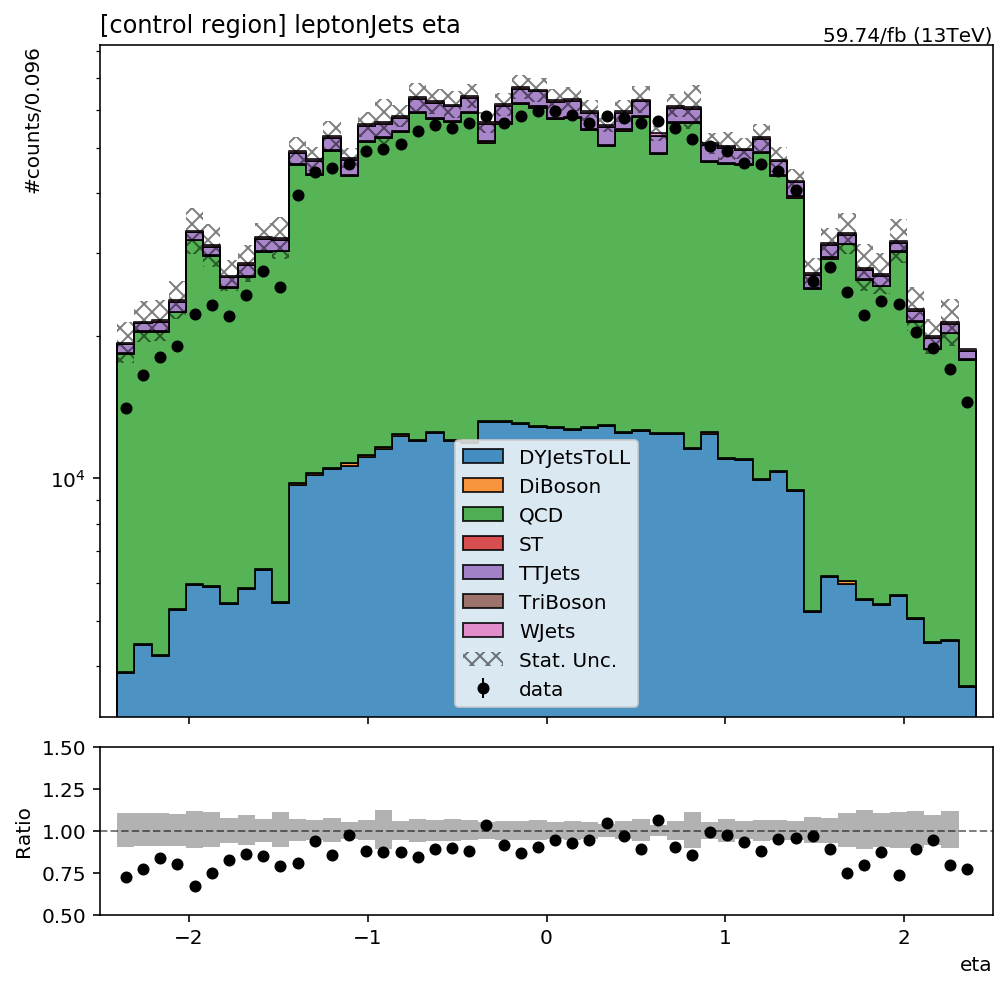

In [48]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['eta_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='all',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['eta_cat']['data'], overlay='cat', ax=ax,
           overflow='all', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['eta_cat']['data'].sum('cat'), output['eta_cat'][notdata].sum('cat'),
              ax=rax, overflow='all', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets eta', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

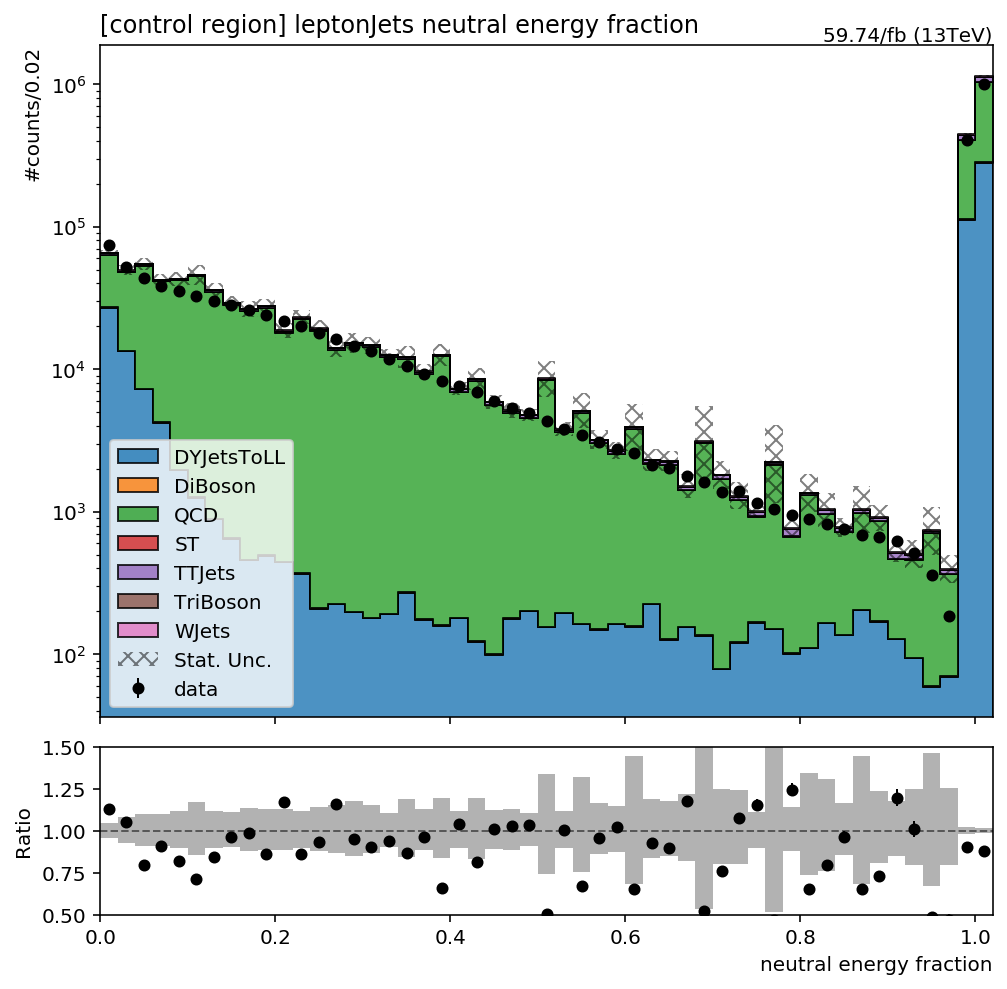

In [47]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['nef_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['nef_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['nef_cat']['data'].sum('cat'), output['nef_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets neutral energy fraction', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

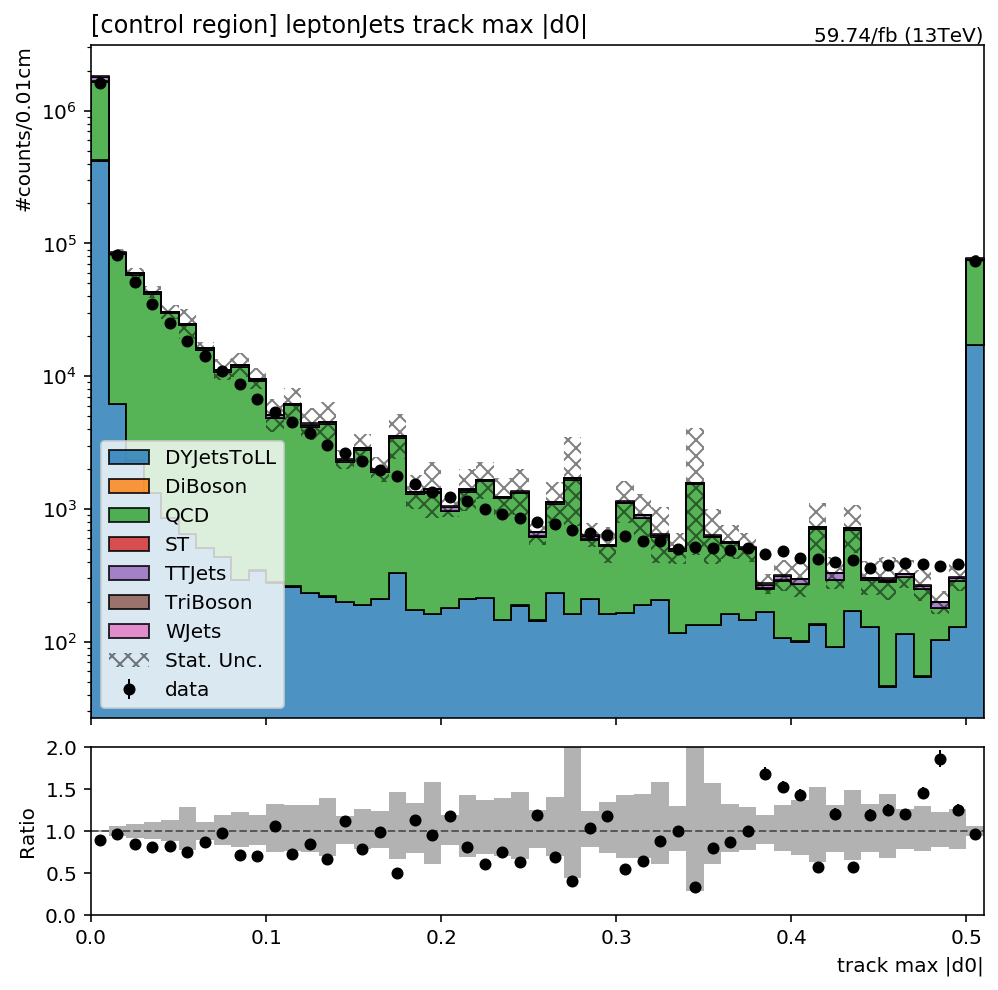

In [25]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['maxd0_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['maxd0_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['maxd0_cat']['data'].sum('cat'), output['maxd0_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets track max |d0|', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

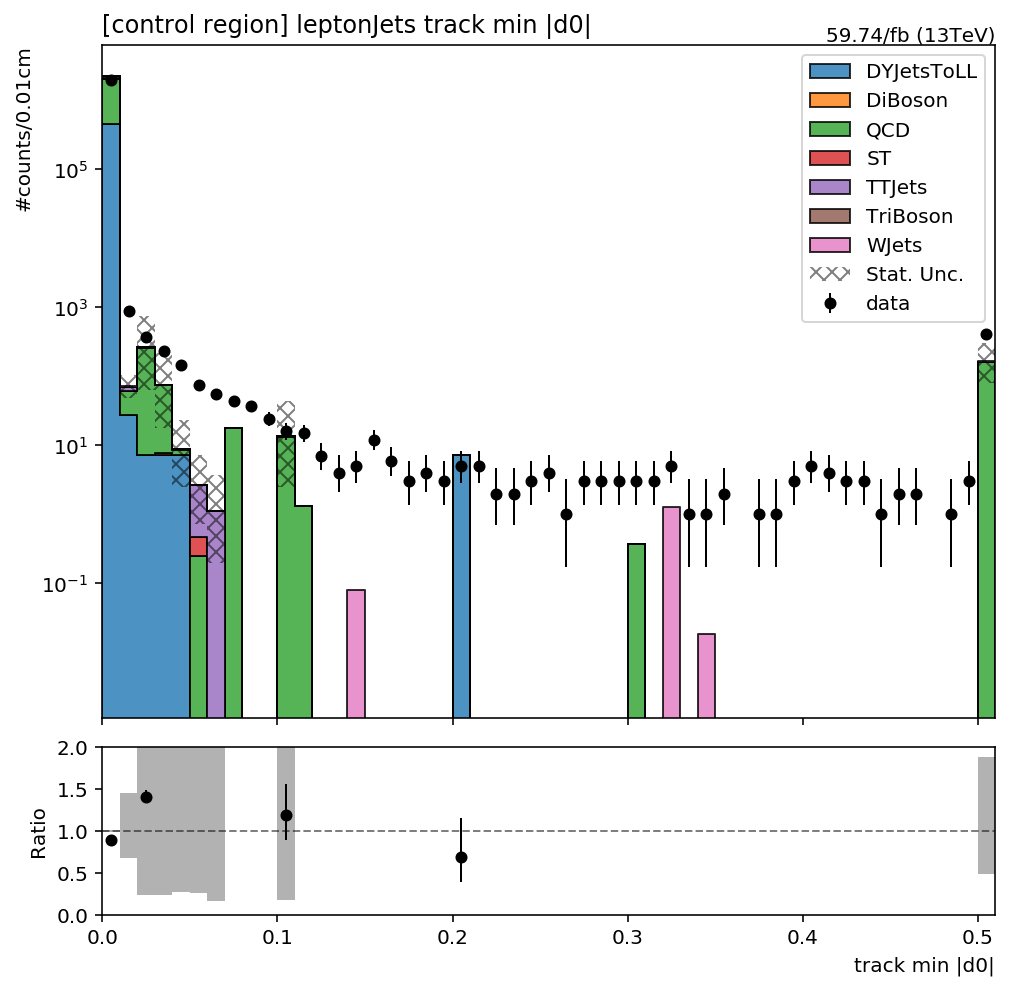

In [27]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['mind0_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['mind0_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['mind0_cat']['data'].sum('cat'), output['mind0_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets track min |d0|', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

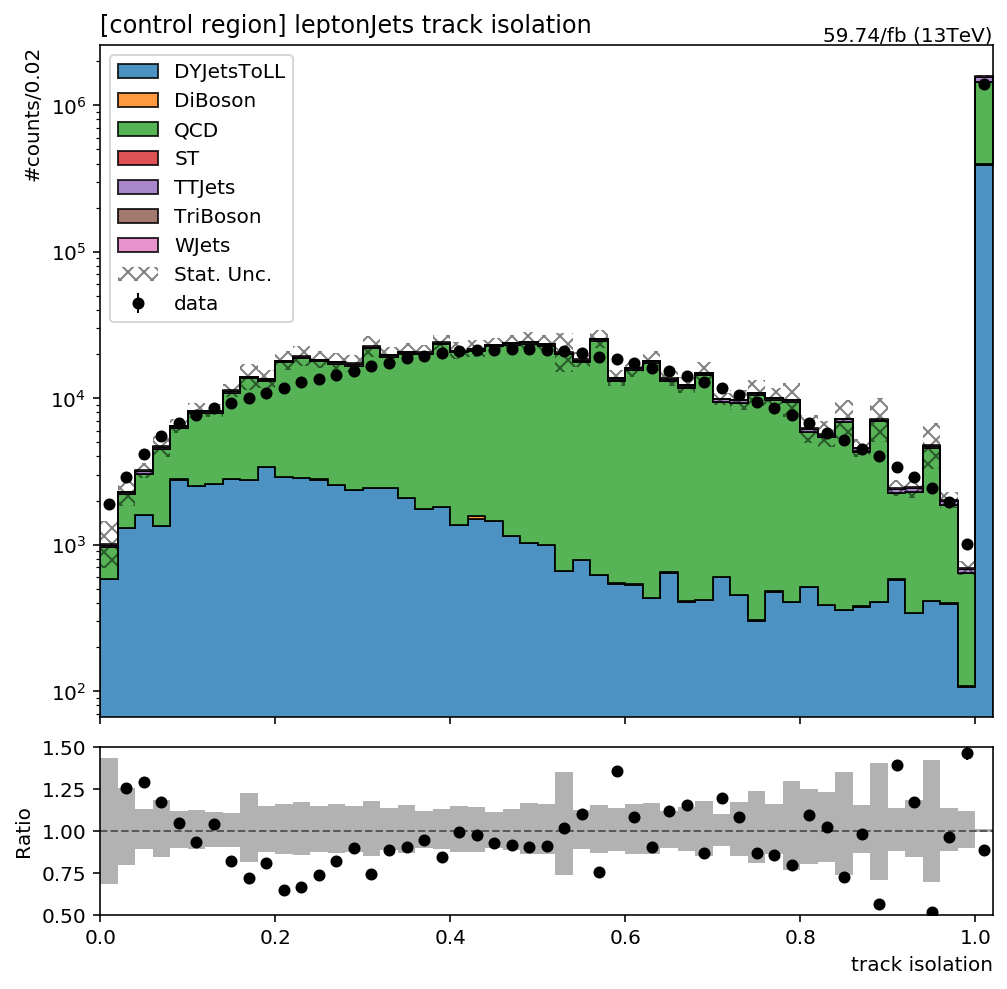

In [46]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['tkiso_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['tkiso_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['tkiso_cat']['data'].sum('cat'), output['tkiso_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets track isolation', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

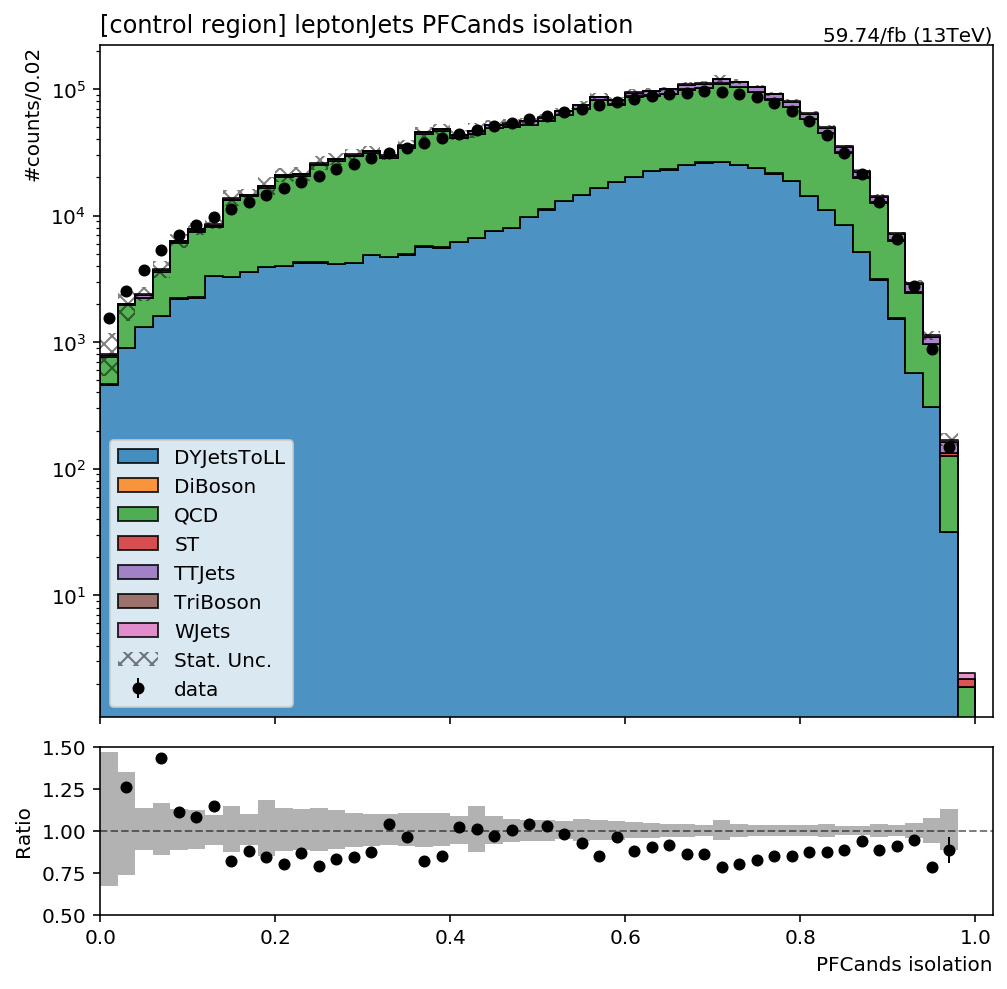

In [45]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['pfiso_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['pfiso_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['pfiso_cat']['data'].sum('cat'), output['pfiso_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets PFCands isolation', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

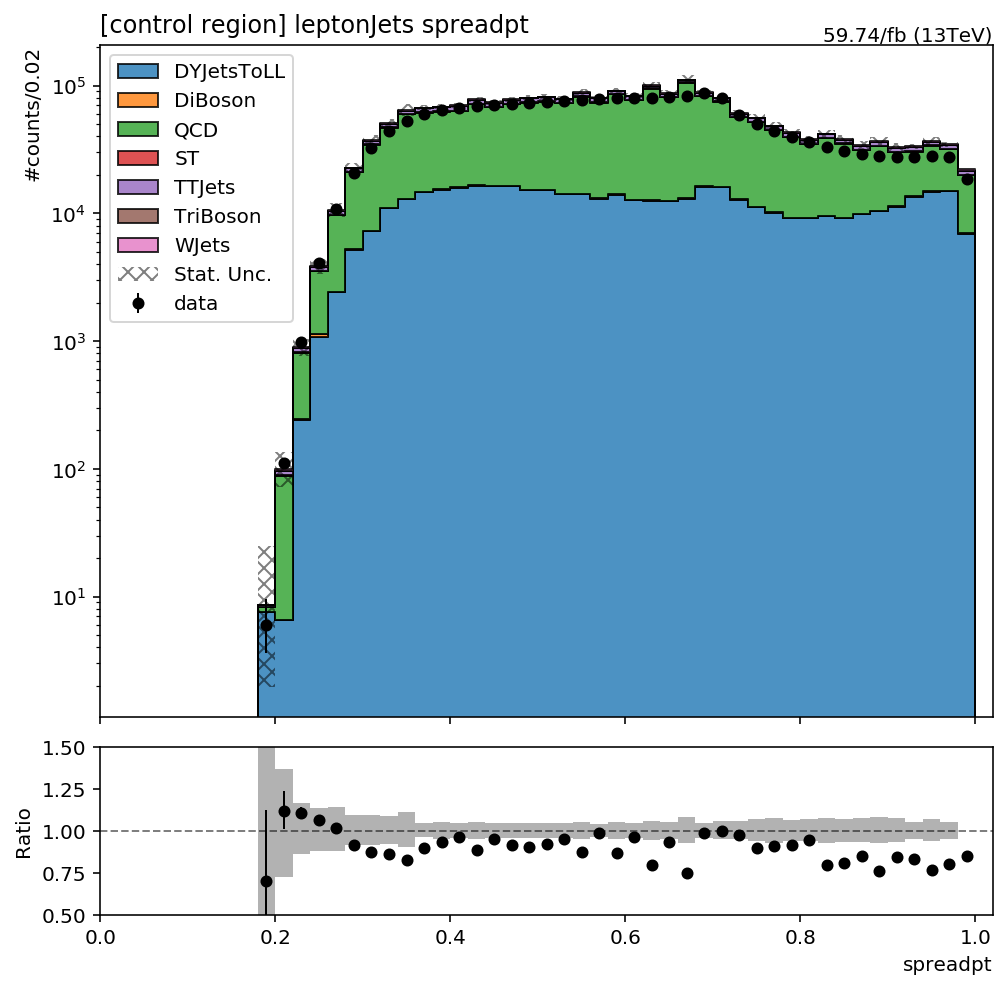

In [44]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['spreadpt_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['spreadpt_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['spreadpt_cat']['data'].sum('cat'), output['spreadpt_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets spreadpt', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

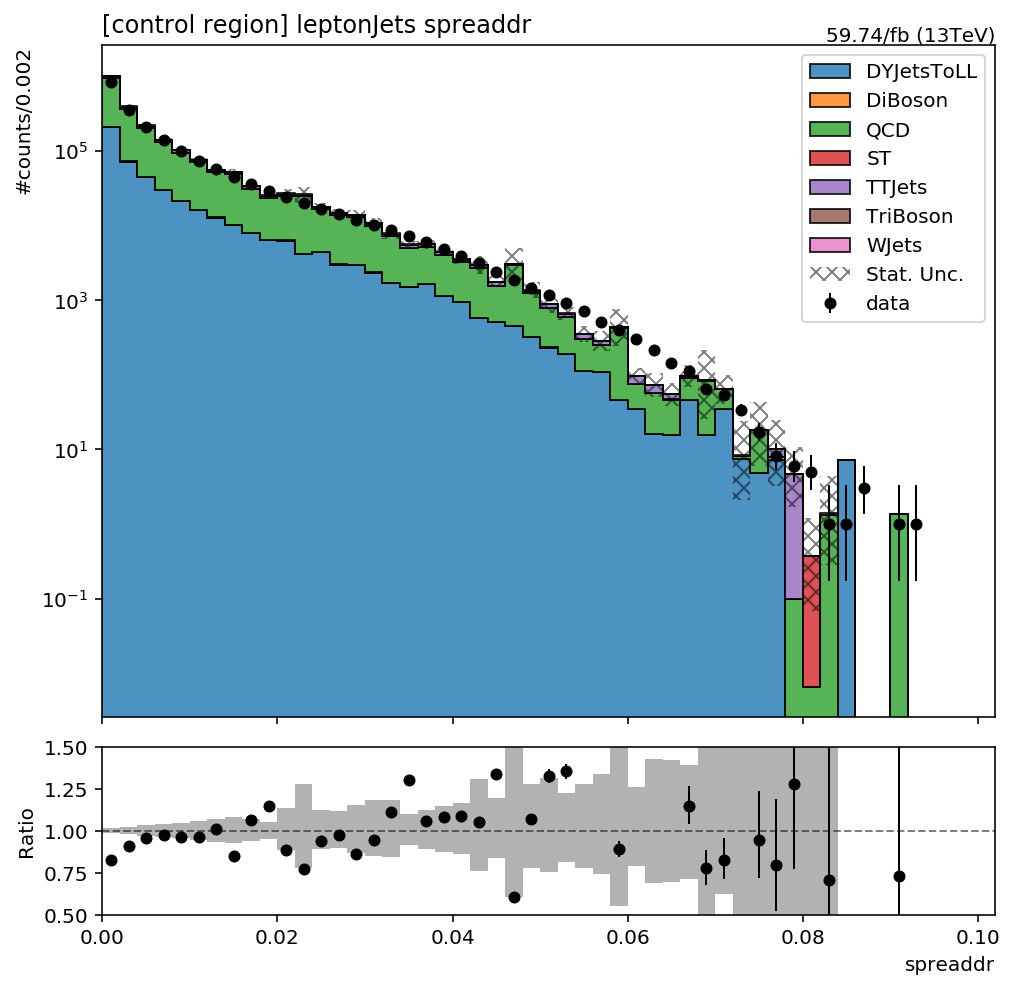

In [43]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['spreaddr_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['spreaddr_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['spreaddr_cat']['data'].sum('cat'), output['spreaddr_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets spreaddr', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

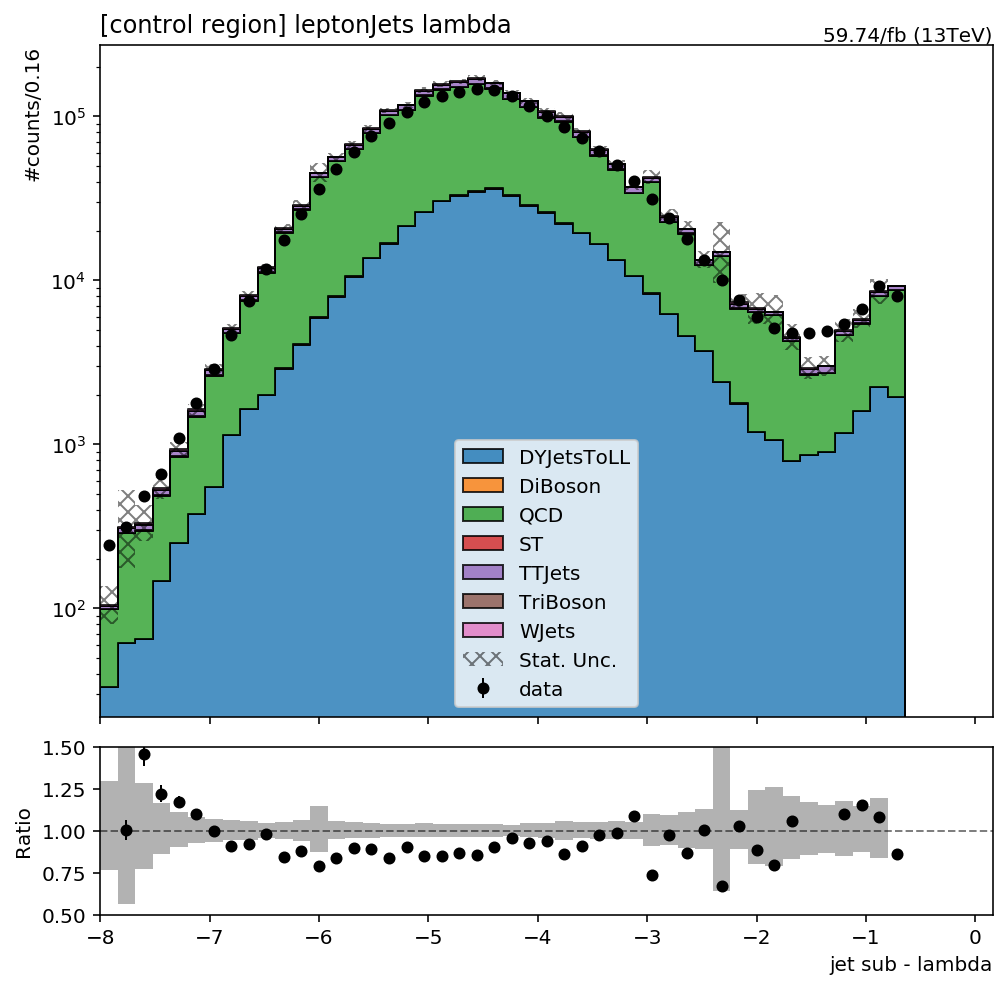

In [42]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['lamb_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['lamb_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['lamb_cat']['data'].sum('cat'), output['lamb_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets lambda', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

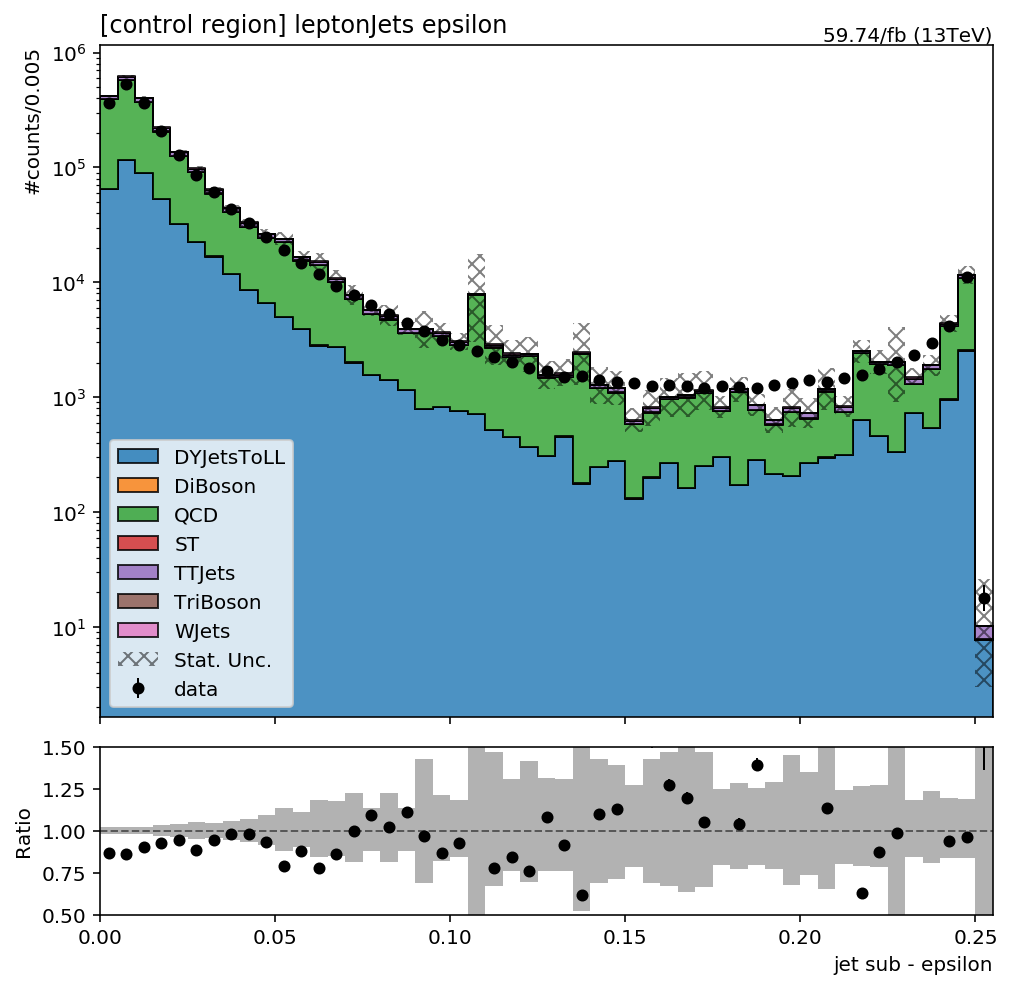

In [41]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['epsi_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['epsi_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['epsi_cat']['data'].sum('cat'), output['epsi_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets epsilon', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

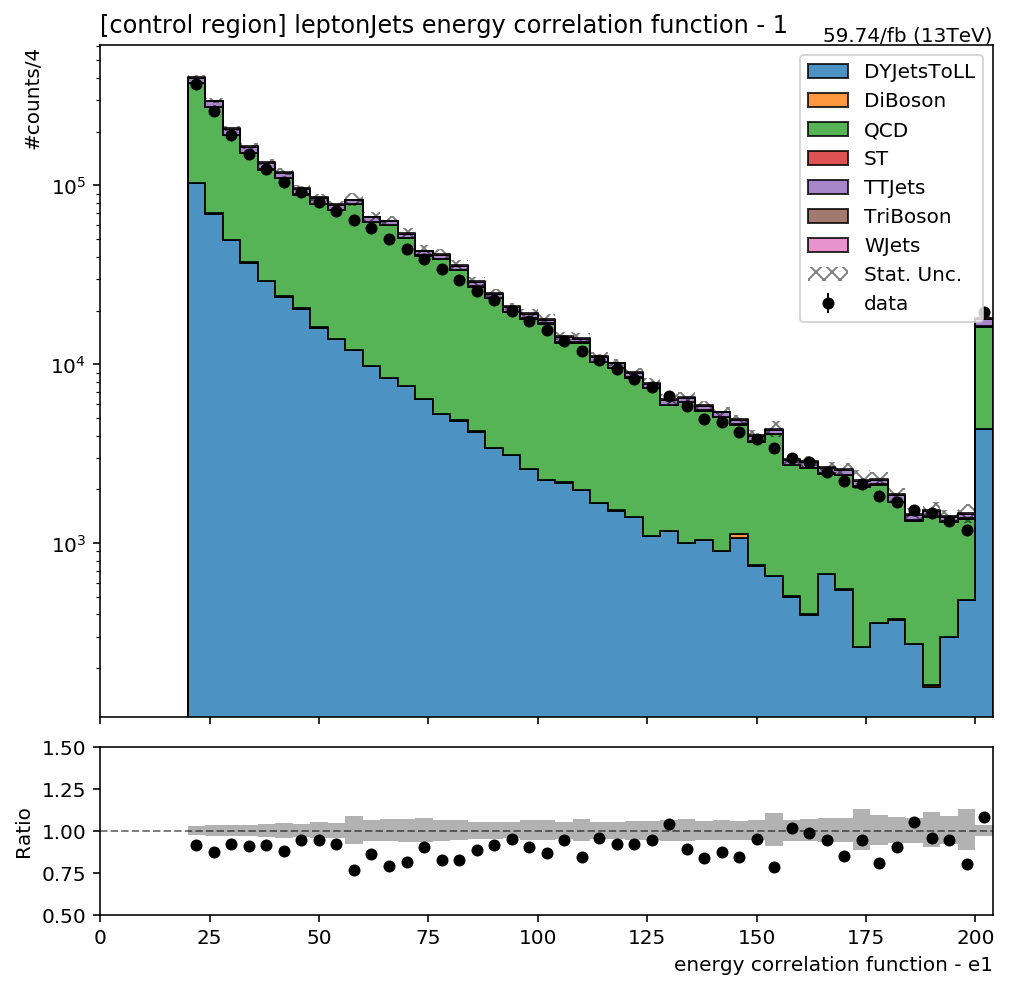

In [36]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['ecfe1_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['ecfe1_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['ecfe1_cat']['data'].sum('cat'), output['ecfe1_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets energy correlation function - 1', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

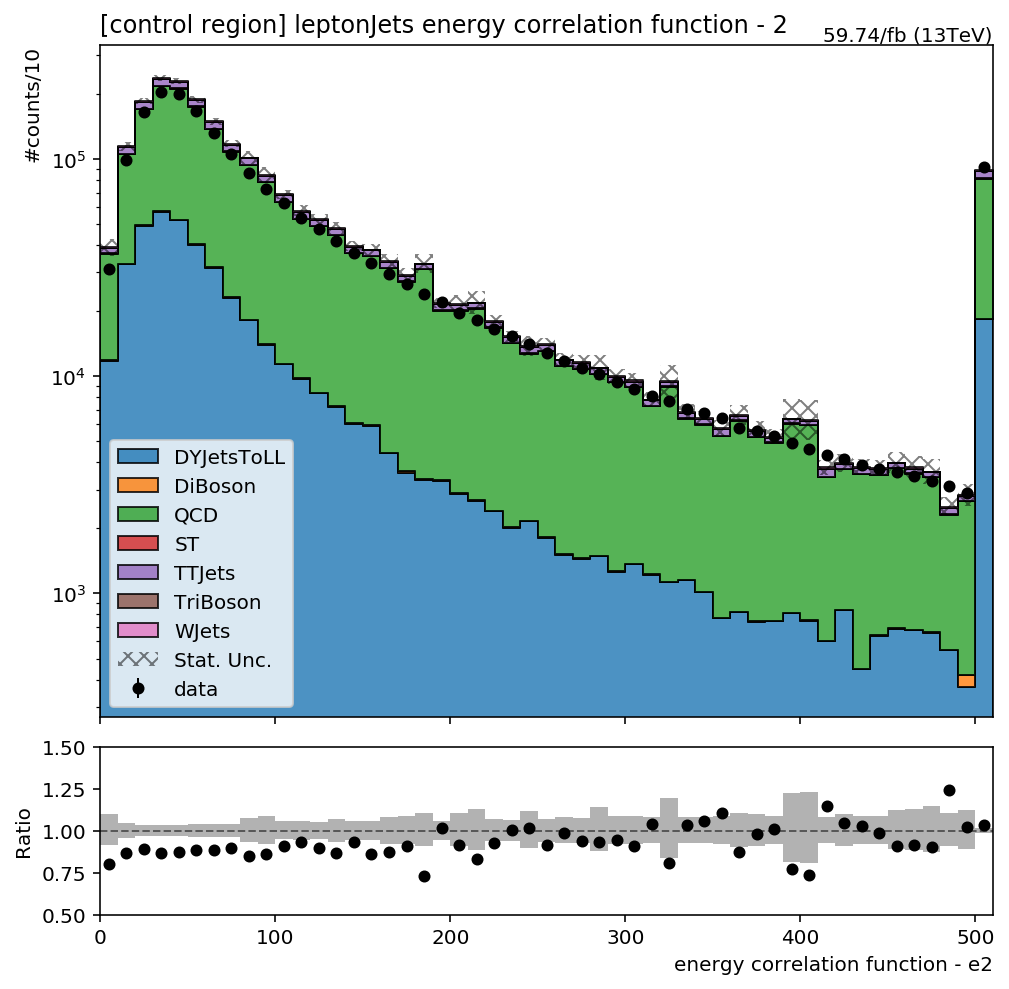

In [37]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['ecfe2_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['ecfe2_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['ecfe2_cat']['data'].sum('cat'), output['ecfe2_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets energy correlation function - 2', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

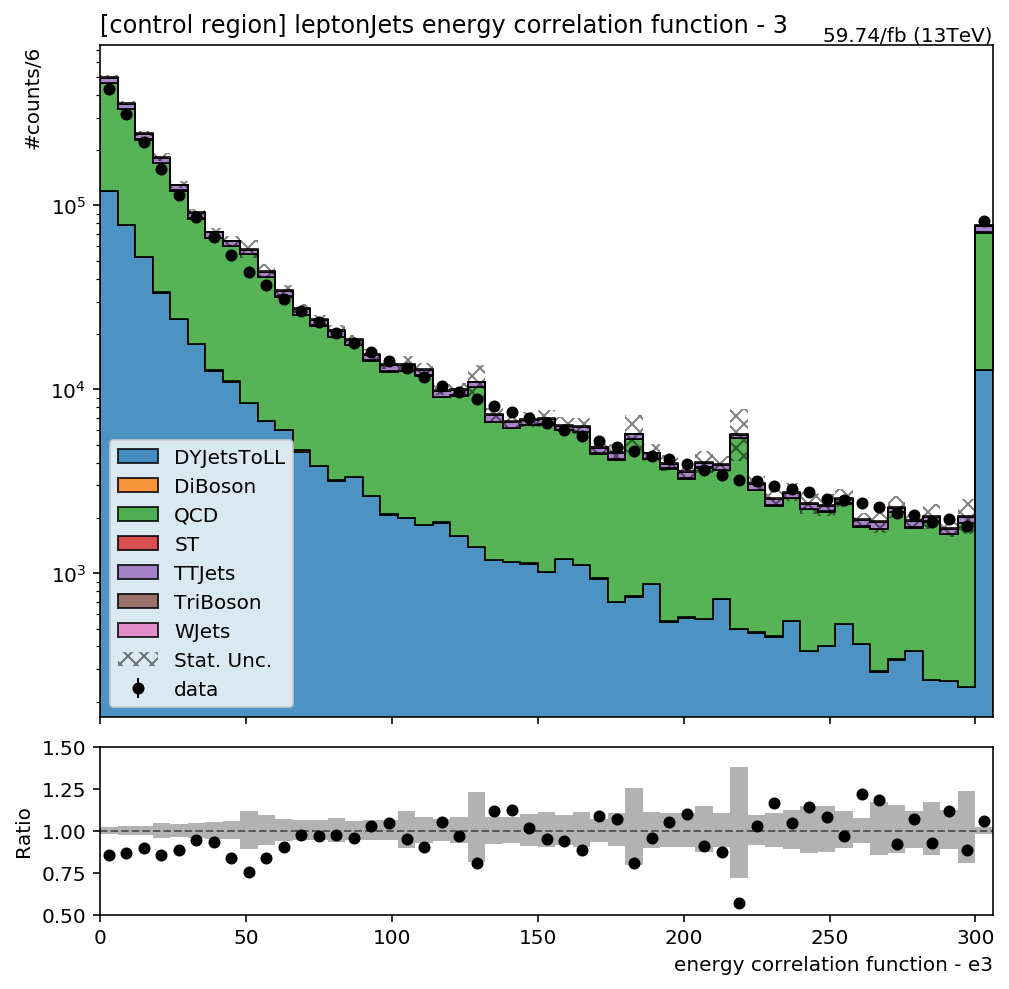

In [38]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['ecfe3_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['ecfe3_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['ecfe3_cat']['data'].sum('cat'), output['ecfe3_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5,1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJets energy correlation function - 3', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

In [40]:
### BDT was trained differently between data/MC ###

# fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
# fig.subplots_adjust(hspace=.07)

# hist.plot1d(output['mva_cat'][notdata], overlay='cat', ax=ax,
#            clear=False, stack=True, overflow='over',
#            line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
# hist.plot1d(output['mva_cat']['data'], overlay='cat', ax=ax,
#            overflow='over', clear=False,
#            error_opts=data_err_opts)
# ax.autoscale(axis='x', tight=True)
# ax.set_yscale('log')
# ax.set_xlabel(None)
# leg=ax.legend()

# hist.plotratio(output['mva_cat']['data'].sum('cat'), output['mva_cat'][notdata].sum('cat'),
#               ax=rax, overflow='over', unc='num',
#               error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
# rax.set_ylabel('Ratio')
# rax.set_ylim(0.5,1.5)

# rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
# ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# ax.set_title('[control region] leptonJets BDT value', x=0.0, ha="left")
# ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

### leptonJet pair
- invariant mass
- delta phi

In [50]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        mass_axis = hist.Bin("mass", "invM [GeV]", 50, 0, 500)
        dphi_axis = hist.Bin('dphi', "$\Delta\Phi$", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("#counts/10GeV", dataset_axis, mass_axis),
            'dphi': hist.Hist("#counts/$\pi$/50", dataset_axis, dphi_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'],
                    py=df['gen_p4.fCoordinates.fY'],
                    pz=df['gen_p4.fCoordinates.fZ'],
                    energy=df['gen_p4.fCoordinates.fT'],
                    pid=df['gen_pid'],
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
        leadingLjPair_ = leadingLjPair[controlregion]
        dphi_ = np.abs(leadingLjPair_.i0.p4.delta_phi(leadingLjPair_.i1.p4))
        wgt = wgt[controlregion.flatten()]

        output['mass'].fill(dataset=dataset, mass=leadingLjPair_.mass.flatten(), weight=wgt)
        output['dphi'].fill(dataset=dataset, dphi=dphi_.flatten(), weight=wgt)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        
        for k in origidentity:
            # scale
            accumulator[k].scale(bkgscales, axis='dataset')
            # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        return accumulator

In [51]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 6847/6847 [09:19<00:00, 12.25items/s]


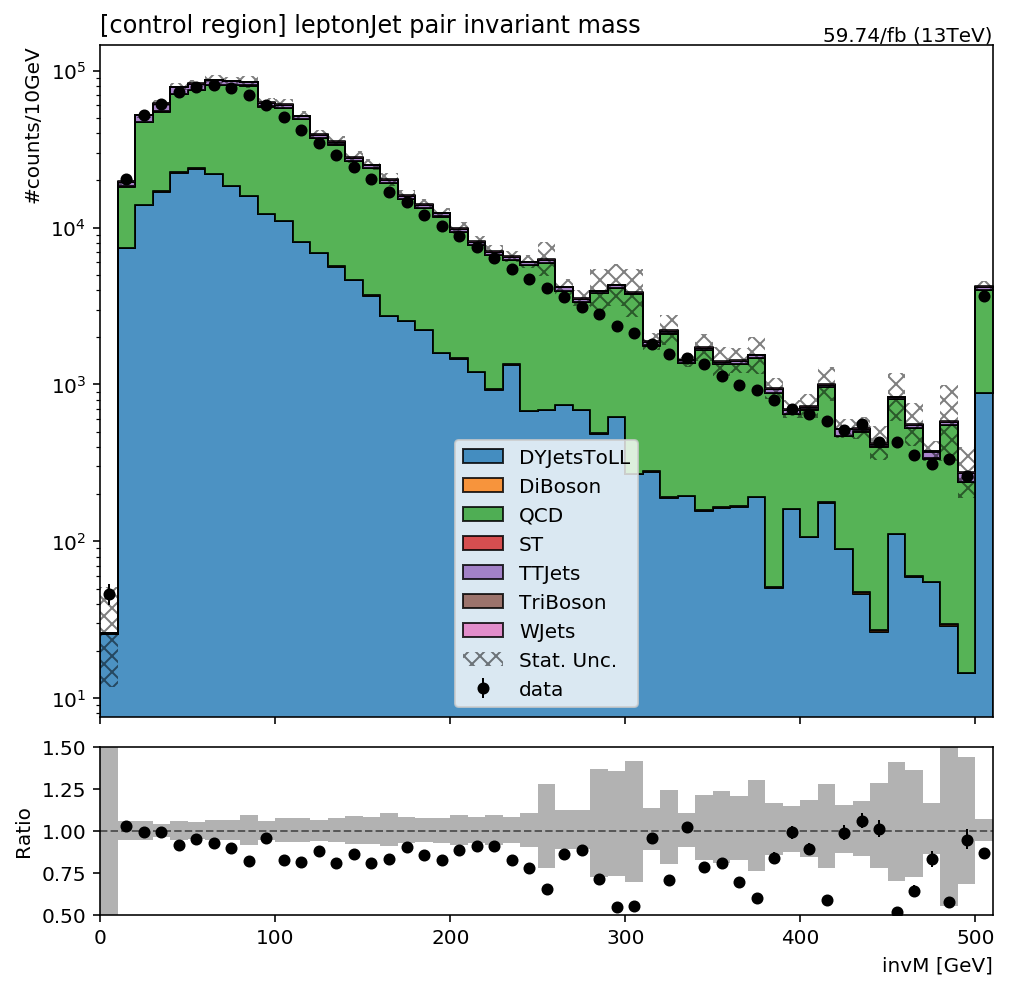

In [52]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['mass_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['mass_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['mass_cat']['data'].sum('cat'), output['mass_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5, 1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJet pair invariant mass', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

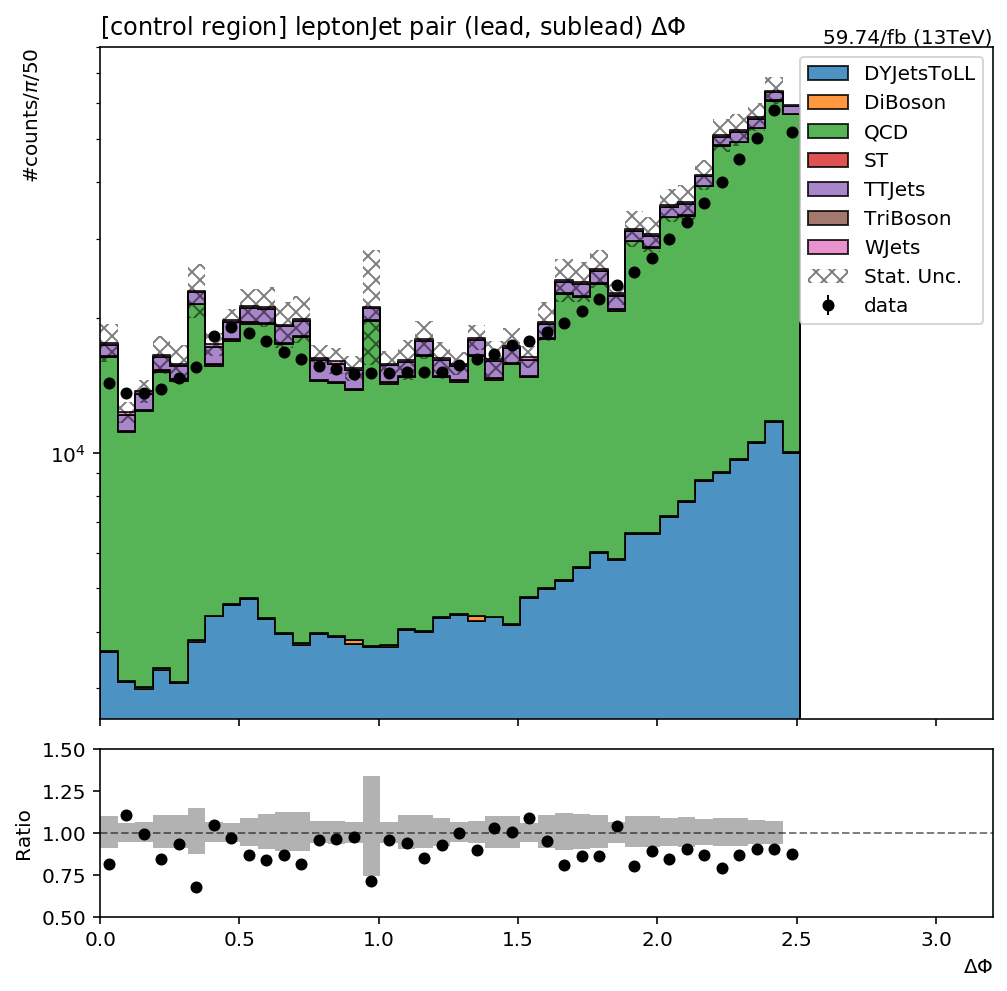

In [53]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['dphi_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['dphi_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['dphi_cat']['data'].sum('cat'), output['dphi_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0.5, 1.5)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leptonJet pair (lead, sublead) $\Delta\Phi$', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

### leading and subleading leptonJets kinematics
- pT, eta

In [31]:
class LeptonJetSeparateProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        pt_axis      = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis     = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        
        self._accumulator = processor.dict_accumulator({
            'pt_lead' : hist.Hist("A.U./16GeV", dataset_axis, pt_axis),
            'eta_lead': hist.Hist("A.U./0.096", dataset_axis, eta_axis),
            'pt_subl' : hist.Hist("A.U./16GeV", dataset_axis, pt_axis),
            'eta_subl': hist.Hist("A.U./0.096", dataset_axis, eta_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ## apply MET filters ##
        metfiltermask = np.logical_or.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[metfiltermask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
            leadingLjPair = leadingLjPair[controlregion]
            _comp = leadingLjPair.i0.pt<leadingLjPair.i1.pt
            leadlj = leadingLjPair.i0*(~_comp)+leadingLjPair.i1*(_comp)
            subllj = leadingLjPair.i0*(_comp)+leadingLjPair.i1*(~_comp)
                        
            output['pt_lead'].fill(dataset=dataset, pt=leadlj.p4.pt.flatten())
            output['pt_subl'].fill(dataset=dataset, pt=subllj.p4.pt.flatten())
            output['eta_lead'].fill(dataset=dataset, eta=leadlj.p4.eta.flatten())
            output['eta_subl'].fill(dataset=dataset, eta=subllj.p4.eta.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        
        for k in origidentity:
            # scale
            accumulator[k].scale(bkgscales, axis='dataset')
            # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        return accumulator

In [32]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetSeparateProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5366/5366 [05:17<00:00, 16.91items/s]


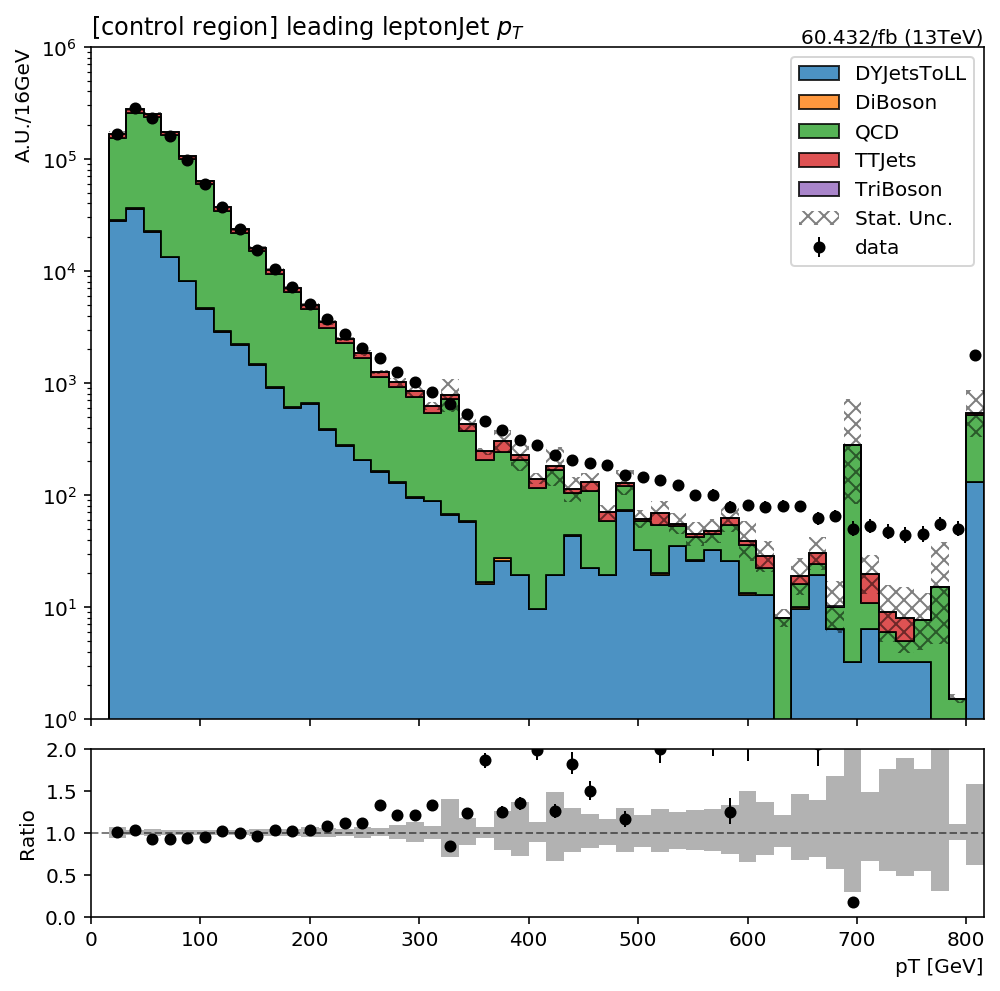

In [34]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['pt_lead_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['pt_lead_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e6])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['pt_lead_cat']['data'].sum('cat'), output['pt_lead_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet $p_T$', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

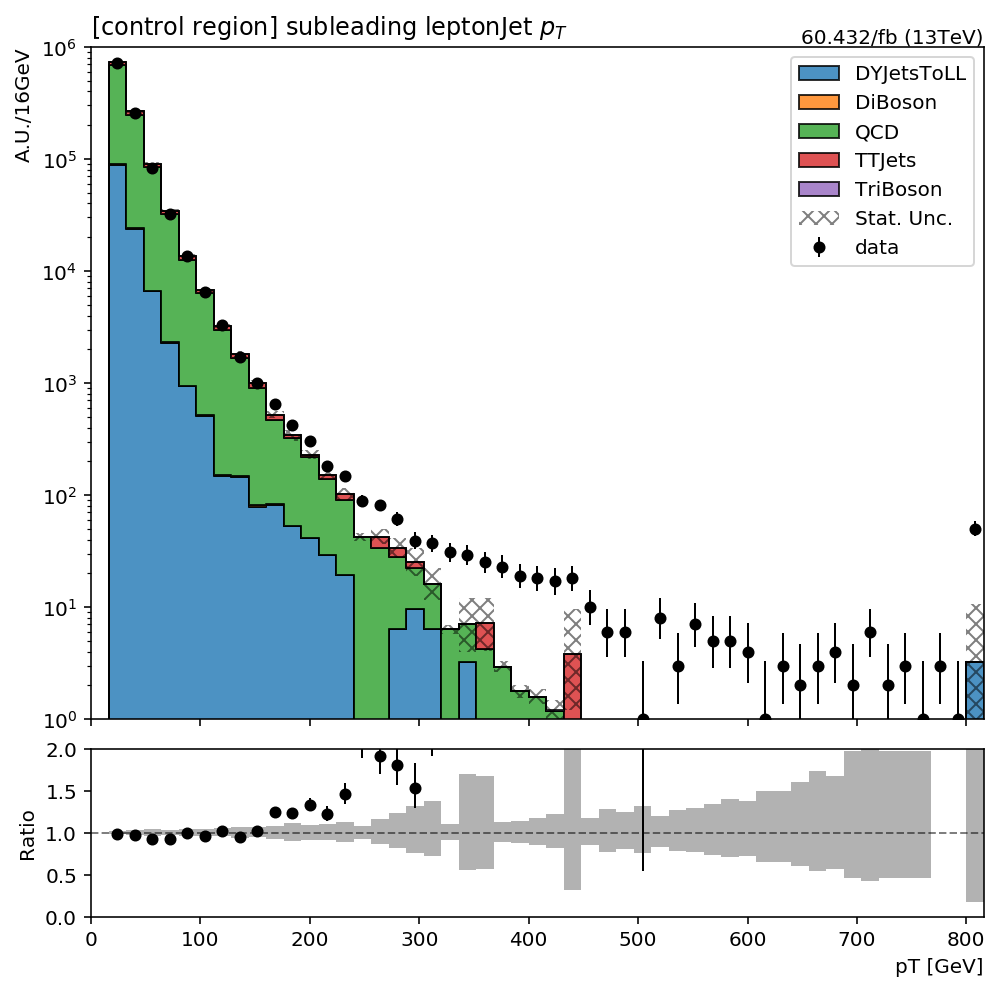

In [35]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['pt_subl_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['pt_subl_cat']['data'], overlay='cat', ax=ax,
           overflow='over', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e6])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['pt_subl_cat']['data'].sum('cat'), output['pt_subl_cat'][notdata].sum('cat'),
              ax=rax, overflow='over', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet $p_T$', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

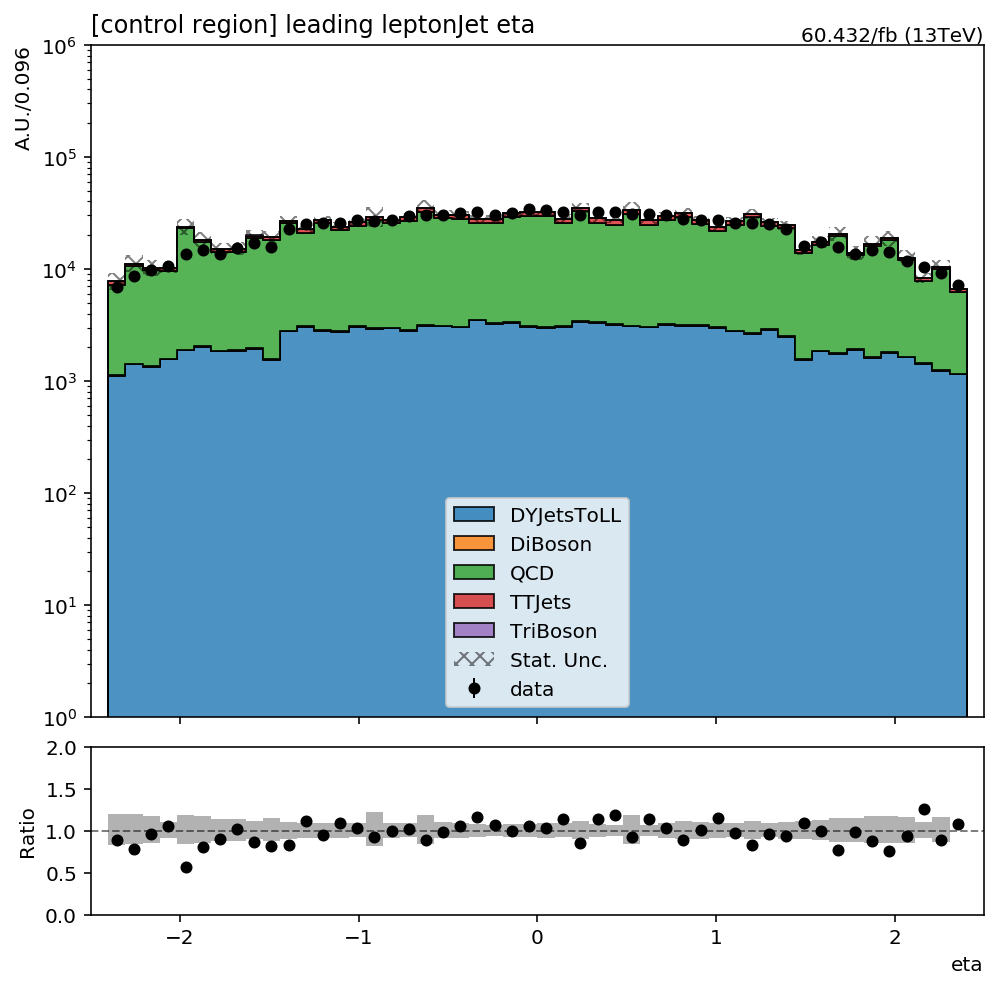

In [37]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['eta_lead_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='all',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['eta_lead_cat']['data'], overlay='cat', ax=ax,
           overflow='all', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e6])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['eta_lead_cat']['data'].sum('cat'), output['eta_lead_cat'][notdata].sum('cat'),
              ax=rax, overflow='all', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] leading leptonJet eta', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

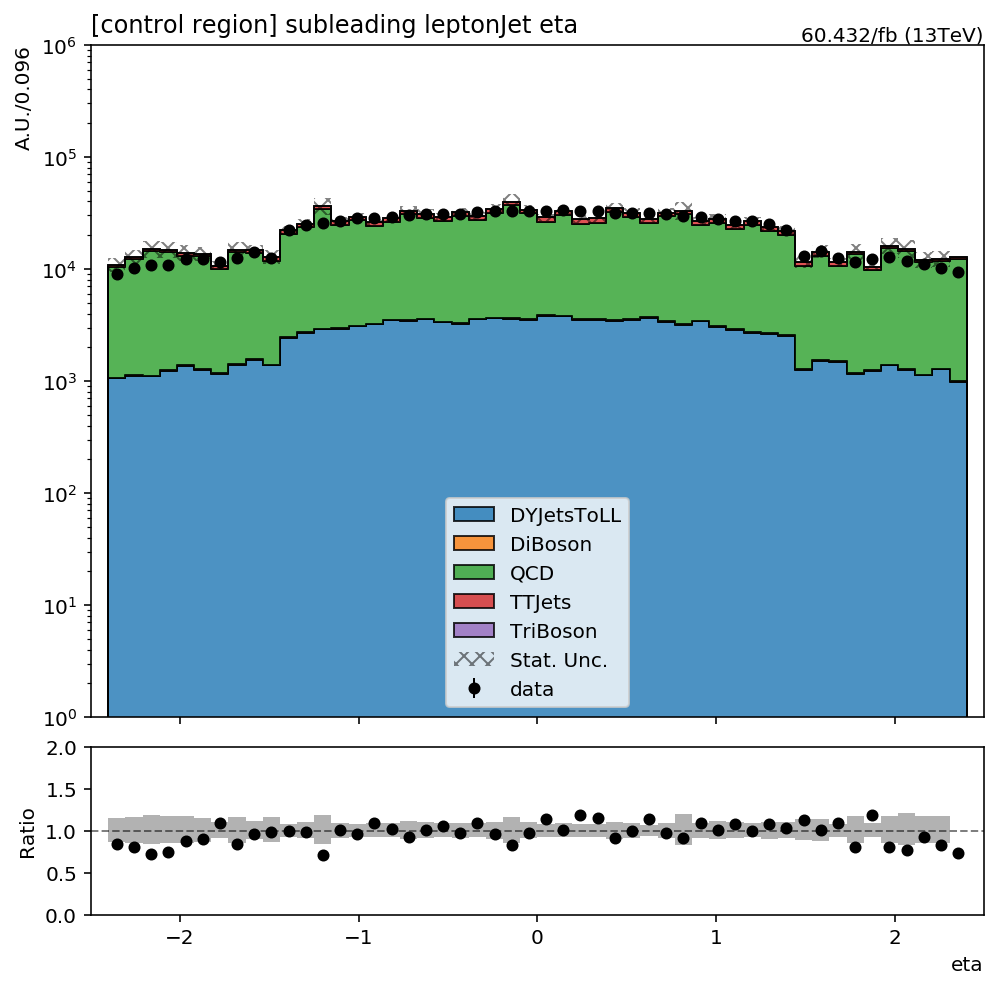

In [38]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['eta_subl_cat'][notdata], overlay='cat', ax=ax,
           clear=False, stack=True, overflow='all',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
hist.plot1d(output['eta_subl_cat']['data'], overlay='cat', ax=ax,
           overflow='all', clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim([1, 1e6])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['eta_subl_cat']['data'].sum('cat'), output['eta_subl_cat'][notdata].sum('cat'),
              ax=rax, overflow='all', unc='num',
              error_opts=data_err_opts, denom_fill_opts={}, guide_opts={})
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[control region] subleading leptonJet eta', x=0.0, ha="left")
ax.text(1,1,'60.432/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

---